In [ ]:
! ls

images			 models			     pretrained_on_meat.ipynb
inference_flowers.ipynb  Pretrained_on_flower.ipynb  Untitled.ipynb


In [2]:
# Only once 
# ! git clone https://gitlab.com/kvm108/models.git

In [3]:
% cd models/research/slim

/home/xoriant/PycharmProjects/meat_classification_try/meat_tf/slim/models/research/slim


In [4]:
! ls

back_train_m2				incp_v3_m2_train
BUILD					incp_v3_m2_train_01
checkpoints				__init__.py
datasets				label_image.py
deployment				nets
download_and_convert_data.py		preprocessing
eval_image_classifier.py		pretrained_checkpoints
events.out.tfevents.1539770716.xoriant	print_pb.py
export_inference_graph.py		README.md
export_inference_graph_test.py		results
flowers					scripts
freeze_graph.py				setup.py
freeze_graph_so.py			slim_walkthrough.ipynb
frozen_inf_graph1.pb			train_image_classifier.py
frozen_inf_graph.pb			train_test_70_10_30
froz_incp_v3.pb				v3_10000_01
inceptionv3_meat_001			v3_1487_97
incp_01_10000				v3_3000
incp_01_1200_97				v3_5000
incp_v3_m2_1				WORKSPACE


In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

# Tesnsorflow libraries + slim helper 
import tensorflow as tf
from datasets import dataset_utils

In [6]:
# Step 1 : Convert images to tf record format
! python download_and_convert_data.py --dataset_name=custom --dataset_dir=../../../../images/train/

Dataset files already exist. Exiting without re-creating them.


In [7]:
! ls ../../../../images/train/

1				      custom_train_00004-of-00005.tfrecord
2				      custom_validation_00000-of-00005.tfrecord
3				      custom_validation_00001-of-00005.tfrecord
custom_train_00000-of-00005.tfrecord  custom_validation_00002-of-00005.tfrecord
custom_train_00001-of-00005.tfrecord  custom_validation_00003-of-00005.tfrecord
custom_train_00002-of-00005.tfrecord  custom_validation_00004-of-00005.tfrecord
custom_train_00003-of-00005.tfrecord  labels.txt


In [8]:
# Step 2 : checking images directory - Make sure *.tfrecord fiels present - both train + validation
# set path to prev cells path
images_data_dir = '../../../../images/train/'

test {'train': 70, 'validation': 10, 'test': 20}


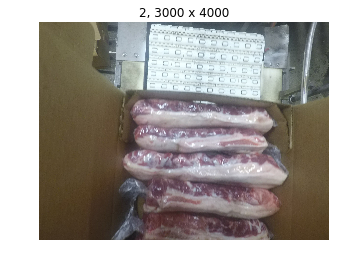

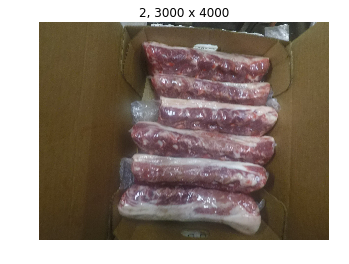

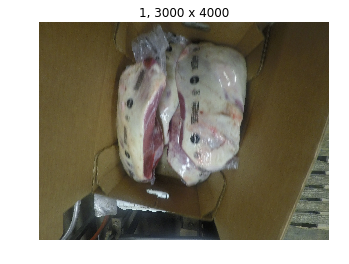

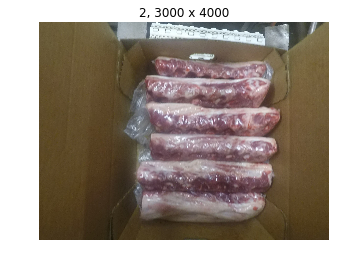

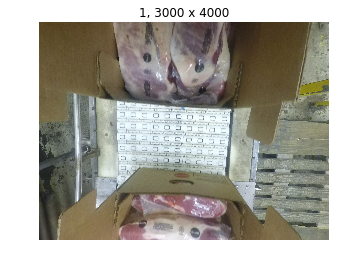

In [26]:
# Visualize the dataset : Try both 'validation' and 'train' in "custom.get_split(<HERE>, images_data_dir)"

from datasets import custom
import tensorflow as tf

from tensorflow.contrib import slim

#TODO : Change to tf.data

NO_OF_IMAGES = 5

with tf.Graph().as_default(): 
    dataset = custom.get_split('test', '../../../../images/test')
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(NO_OF_IMAGES):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (class_name, height, width))
                plt.axis('off')
                plt.show()

In [9]:
# Download the Inception V3 checkpoint

from datasets import dataset_utils

url = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'

# "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = 'checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)
    dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

In [10]:
! ls checkpoints/

inception_v3_2016_08_28.tar.gz	inception_v3.ckpt


In [11]:
# Generic helper fucntion for Batching images

from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [19]:
# step 

import os

from datasets import custom
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v3.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                break
        else:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
      variables_to_restore)


train_dir = 'traintest_split_70_10_20_10000'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = custom.get_split('train', images_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, _ = inception.inception_v3(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/total_loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=1610)
    
#     TODO :  Figure out these metrics too + get rid of deprecated warnings
#     # Choose the metrics to compute:
#     prediction=tf.argmax(logits,1)
#     names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
#         "accuracy": slim.metrics.accuracy(predictions, labels),
#         "mse": slim.metrics.mean_squared_error(predictions, labels),
#     })
    
#     # Define the summaries to write:
#     for metric_name, metric_value in metrics_to_values.iteritems():
#         tf.summary.scalar(metric_name, metric_value)
                        
print('Finished training. Last batch loss %f' % final_loss)

INFO:tensorflow:Restoring parameters from inceptionv3_meat_001/model.ckpt-1600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path inceptionv3_meat_001/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:Recording summary at step 1600.
INFO:tensorflow:global step 1601: loss = 0.1706 (49.676 sec/step)
INFO:tensorflow:global step 1602: loss = 0.1701 (24.453 sec/step)
INFO:tensorflow:global step 1603: loss = 0.1699 (23.928 sec/step)
INFO:tensorflow:global step 1604: loss = 0.1698 (24.105 sec/step)
INFO:tensorflow:global step 1605: loss = 0.1712 (23.913 sec/step)
INFO:tensorflow:global step 1606: loss = 0.1699 (24.865 sec/step)
INFO:tensorflow:global step 1607: loss = 0.1696 (24.312 sec/step)
INFO:tensorflow:global step 1608: loss = 0.1698 (23.856 sec/step)
INFO:tensorflow:global step 1609: loss = 0.1694 (24.478 sec/step)
INFO:tensorflow:global step 1610: loss = 0.1697 (24.973

In [20]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path='inceptionv3_meat_001' \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating inceptionv3_meat_001/model.ckpt-1610
INFO:tensorflow:Starting evaluation at 2018-10-10-05:25:09
INFO:tensorflow:Graph was finalized.
2018-10-10 10:55:10.165143: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
INFO:tensorflow:Restoring parameters from

## Q's - Why accuracy has dipped? Why tensorboard cannot dispaly

In [13]:
! ls

back_train_m2			incp_v3_m2_train_01
BUILD				__init__.py
checkpoints			nets
datasets			preprocessing
deployment			pretrained_checkpoints
download_and_convert_data.py	README.md
eval_image_classifier.py	results
export_inference_graph.py	scripts
export_inference_graph_test.py	setup.py
flowers				slim_walkthrough.ipynb
inceptionv3_meat_001		train_image_classifier.py
incp_v3_m2_1			WORKSPACE
incp_v3_m2_train


#### LR - 0.01 Iter - 10000

In [12]:
!python train_image_classifier.py \
    --train_dir=train_test_70_10_30 \
    --dataset_dir=../../../../images/train/ \
    --dataset_name=custom \
    --dataset_split_name=train \
    --model_name=inception_v3 \
    --checkpoint_path=checkpoints/inception_v3.ckpt \
    --checkpoint_exclude_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --trainable_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --learning_rate=0.01 \
    --max_number_of_steps=10000 \
    --clone_on_cpu=True

Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.
INFO:tensorflow:Fine-tuning from checkpoints/inception_v3.ckpt
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
2018-10-17 19:04:38.220294: I tensorflow/core/platform/cpu_feature_guard.cc

INFO:tensorflow:global step 510: loss = 0.7525 (6.242 sec/step)
INFO:tensorflow:global step 520: loss = 0.4064 (6.308 sec/step)
INFO:tensorflow:global step 530: loss = 0.5911 (6.213 sec/step)
INFO:tensorflow:global step 540: loss = 0.4656 (6.261 sec/step)
INFO:tensorflow:global step 550: loss = 0.6842 (6.238 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:global_step/sec: 0.156491
INFO:tensorflow:Recording summary at step 553.
INFO:tensorflow:global step 560: loss = 0.9732 (6.284 sec/step)
INFO:tensorflow:global step 570: loss = 0.5468 (6.245 sec/step)
INFO:tensorflow:global step 580: loss = 0.4984 (6.277 sec/step)
INFO:tensorflow:global step 590: loss = 0.5902 (6.330 sec/step)
INFO:tensorflow:global step 600: loss = 0.6325 (6.396 sec/step)
INFO:tensorflow:global step 610: loss = 0.4828 (6.339 sec/step)
INFO:tensorflow:global step 620: loss = 0.4872 (6.273 sec/step)
INFO:tensorflow:global step 630: loss = 0.5266 (6.297 sec/step)
INFO:t

INFO:tensorflow:global step 1550: loss = 0.6380 (6.281 sec/step)
INFO:tensorflow:global step 1560: loss = 0.6361 (6.233 sec/step)
INFO:tensorflow:global step 1570: loss = 0.5051 (6.239 sec/step)
INFO:tensorflow:global step 1580: loss = 0.5414 (6.294 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 1584.
INFO:tensorflow:global step 1590: loss = 0.5663 (6.278 sec/step)
INFO:tensorflow:global step 1600: loss = 0.4883 (6.335 sec/step)
INFO:tensorflow:global step 1610: loss = 0.5980 (6.190 sec/step)
INFO:tensorflow:global step 1620: loss = 0.6169 (6.303 sec/step)
INFO:tensorflow:global step 1630: loss = 0.4354 (6.263 sec/step)
INFO:tensorflow:global step 1640: loss = 0.5448 (6.301 sec/step)
INFO:tensorflow:global step 1650: loss = 0.5302 (6.171 sec/step)
INFO:tensorflow:global step 1660: loss = 0.4479 (6.196 sec/step)
INFO:tensorflow:global step 1670: loss = 0.5122 (6.188 sec/step)
INFO:tensorflow:Saving checkpoint 

INFO:tensorflow:global step 2610: loss = 0.5525 (6.190 sec/step)
INFO:tensorflow:global step 2620: loss = 0.8898 (6.181 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 2627.
INFO:tensorflow:global step 2630: loss = 0.4906 (6.220 sec/step)
INFO:tensorflow:global step 2640: loss = 0.5039 (6.232 sec/step)
INFO:tensorflow:global step 2650: loss = 0.5834 (6.146 sec/step)
INFO:tensorflow:global step 2660: loss = 0.5725 (6.234 sec/step)
INFO:tensorflow:global step 2670: loss = 0.5542 (6.204 sec/step)
INFO:tensorflow:global step 2680: loss = 0.5157 (6.139 sec/step)
INFO:tensorflow:global step 2690: loss = 0.3939 (6.220 sec/step)
INFO:tensorflow:global step 2700: loss = 0.4972 (6.130 sec/step)
INFO:tensorflow:global step 2710: loss = 0.4853 (6.220 sec/step)
INFO:tensorflow:global step 2720: loss = 0.4891 (6.161 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording 

INFO:tensorflow:global step 3670: loss = 0.5138 (6.138 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 3678.
INFO:tensorflow:global step 3680: loss = 0.3947 (6.206 sec/step)
INFO:tensorflow:global step 3690: loss = 0.5903 (6.131 sec/step)
INFO:tensorflow:global step 3700: loss = 0.5860 (6.208 sec/step)
INFO:tensorflow:global step 3710: loss = 0.3822 (6.171 sec/step)
INFO:tensorflow:global step 3720: loss = 0.5971 (6.136 sec/step)
INFO:tensorflow:global step 3730: loss = 0.4852 (6.095 sec/step)
INFO:tensorflow:global step 3740: loss = 0.4147 (6.148 sec/step)
INFO:tensorflow:global step 3750: loss = 0.6741 (6.141 sec/step)
INFO:tensorflow:global step 3760: loss = 0.5039 (6.232 sec/step)
INFO:tensorflow:global step 3770: loss = 0.6712 (6.063 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 3774.
INFO:tensorflow:global step 3780: loss = 0.

INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:global step 4730: loss = 0.6138 (11.139 sec/step)
INFO:tensorflow:Recording summary at step 4730.
INFO:tensorflow:global step 4740: loss = 0.3918 (6.135 sec/step)
INFO:tensorflow:global step 4750: loss = 0.7389 (6.130 sec/step)
INFO:tensorflow:global step 4760: loss = 0.9169 (6.126 sec/step)
INFO:tensorflow:global step 4770: loss = 0.6294 (6.120 sec/step)
INFO:tensorflow:global step 4780: loss = 0.6215 (6.119 sec/step)
INFO:tensorflow:global step 4790: loss = 0.7144 (6.190 sec/step)
INFO:tensorflow:global step 4800: loss = 0.5153 (6.149 sec/step)
INFO:tensorflow:global step 4810: loss = 0.6946 (6.131 sec/step)
INFO:tensorflow:global step 4820: loss = 0.9089 (6.197 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 4825.
INFO:tensorflow:global step 4830: loss = 0.5535 (6.156 sec/step)
INFO:tensorflow:global step 4840: loss = 0

INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 5782.
INFO:tensorflow:global step 5790: loss = 0.4822 (6.253 sec/step)
INFO:tensorflow:global step 5800: loss = 0.5228 (6.149 sec/step)
INFO:tensorflow:global step 5810: loss = 0.5540 (6.163 sec/step)
INFO:tensorflow:global step 5820: loss = 0.5585 (6.122 sec/step)
INFO:tensorflow:global step 5830: loss = 0.5421 (6.145 sec/step)
INFO:tensorflow:global step 5840: loss = 0.4825 (6.170 sec/step)
INFO:tensorflow:global step 5850: loss = 0.5914 (6.188 sec/step)
INFO:tensorflow:global step 5860: loss = 0.4264 (6.164 sec/step)
INFO:tensorflow:global step 5870: loss = 0.5786 (6.145 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 5878.
INFO:tensorflow:global step 5880: loss = 0.4672 (6.133 sec/step)
INFO:tensorflow:global step 5890: loss = 0.4500 (6.219 sec/step)
INFO:tensorflow:global step 5900: loss = 0.

INFO:tensorflow:Recording summary at step 6832.
INFO:tensorflow:global step 6840: loss = 0.4280 (6.255 sec/step)
INFO:tensorflow:global step 6850: loss = 0.4174 (6.212 sec/step)
INFO:tensorflow:global step 6860: loss = 0.4716 (6.218 sec/step)
INFO:tensorflow:global step 6870: loss = 0.5257 (6.217 sec/step)
INFO:tensorflow:global step 6880: loss = 0.5503 (6.172 sec/step)
INFO:tensorflow:global step 6890: loss = 0.4822 (6.202 sec/step)
INFO:tensorflow:global step 6900: loss = 0.4649 (6.231 sec/step)
INFO:tensorflow:global step 6910: loss = 0.5513 (6.212 sec/step)
INFO:tensorflow:global step 6920: loss = 0.7355 (6.184 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 6927.
INFO:tensorflow:global step 6930: loss = 0.6835 (6.217 sec/step)
INFO:tensorflow:global step 6940: loss = 0.5731 (6.137 sec/step)
INFO:tensorflow:global step 6950: loss = 0.5311 (6.172 sec/step)
INFO:tensorflow:global step 6960: loss = 0.6498 (6.

INFO:tensorflow:global step 7890: loss = 0.4289 (6.290 sec/step)
INFO:tensorflow:global step 7900: loss = 0.5630 (6.153 sec/step)
INFO:tensorflow:global step 7910: loss = 0.6218 (6.192 sec/step)
INFO:tensorflow:global step 7920: loss = 0.4333 (6.152 sec/step)
INFO:tensorflow:global step 7930: loss = 0.5782 (6.197 sec/step)
INFO:tensorflow:global step 7940: loss = 0.4945 (6.214 sec/step)
INFO:tensorflow:global step 7950: loss = 0.5205 (6.167 sec/step)
INFO:tensorflow:global step 7960: loss = 0.4535 (6.129 sec/step)
INFO:tensorflow:global step 7970: loss = 0.5665 (6.209 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 7978.
INFO:tensorflow:global step 7980: loss = 0.6183 (6.133 sec/step)
INFO:tensorflow:global step 7990: loss = 0.4943 (6.172 sec/step)
INFO:tensorflow:global step 8000: loss = 0.5169 (6.136 sec/step)
INFO:tensorflow:global step 8010: loss = 0.5092 (6.208 sec/step)
INFO:tensorflow:global step 8020: 

INFO:tensorflow:global step 8950: loss = 0.5717 (6.141 sec/step)
INFO:tensorflow:global step 8960: loss = 0.6309 (6.120 sec/step)
INFO:tensorflow:global step 8970: loss = 0.6875 (6.147 sec/step)
INFO:tensorflow:global step 8980: loss = 0.6736 (6.070 sec/step)
INFO:tensorflow:global step 8990: loss = 0.5041 (6.085 sec/step)
INFO:tensorflow:global step 9000: loss = 0.4469 (6.159 sec/step)
INFO:tensorflow:global step 9010: loss = 0.6446 (6.125 sec/step)
INFO:tensorflow:global step 9020: loss = 0.4862 (6.110 sec/step)
INFO:tensorflow:global step 9030: loss = 0.4742 (6.089 sec/step)
INFO:tensorflow:Saving checkpoint to path train_test_70_10_30/model.ckpt
INFO:tensorflow:Recording summary at step 9033.
INFO:tensorflow:global step 9040: loss = 0.7008 (6.130 sec/step)
INFO:tensorflow:global step 9050: loss = 0.5145 (6.164 sec/step)
INFO:tensorflow:global step 9060: loss = 0.6400 (6.137 sec/step)
INFO:tensorflow:global step 9070: loss = 0.5697 (6.162 sec/step)
INFO:tensorflow:global step 9080: 

In [21]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path=train_test_70_10_30 \
    --dataset_dir=../../../../images/train/ \
    --dataset_name=custom \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
validation {'train': 70, 'validation': 10, 'test': 20}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating train_test_70_10_30/model.ckpt-10000
INFO:tensorflow:Starting evaluation at 2018-10-18-12:39:16
INFO:tensorflow:Graph was finalized.
2018-10-18 18:09:16.996048: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to 

In [29]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path=train_test_70_10_30 \
    --dataset_dir=../../../../images/test/ \
    --dataset_name=custom \
    --dataset_split_name=test \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
test {'train': 70, 'validation': 10, 'test': 20}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating train_test_70_10_30/model.ckpt-10000
INFO:tensorflow:Starting evaluation at 2018-10-18-12:57:48
INFO:tensorflow:Graph was finalized.
2018-10-18 18:27:48.597332: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: A

In [14]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path=incp_v3_m2_train \
    --dataset_dir=../../../../images/test/ \
    --dataset_name=custom \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Traceback (most recent call last):
  File "eval_image_classifier.py", line 191, in <module>
    tf.app.run()
  File "/home/xoriant/PycharmProjects/meat_classification_try/venv/lib/python3.6/site-packages/tensorflow/python/platform/app.py", line 125, in run
    _sys.exit(main(argv))
  File "eval_image_classifier.py", line 114, in main
    common_queue_min=FLAGS.batch_size)
  File "/home/xoriant/PycharmProjects/meat_classification_try/venv/lib/python3.6/site-packages/tensorflow/contrib/slim/python/slim/data/dataset_data_provider.py", line 96, in __init__
    scope=scope)
  File "/home/xoriant/PycharmProjects/meat_classification_try/venv/lib/python3.6/site-packages/tensorflow/contrib/slim/python/slim/data/parallel_reader.py", line 238, in parallel_read
    data_files = get_data_files(data_sources)
  File "/home/xoriant/PycharmProjects/meat_classification_try/venv/lib/python3.6/site-packages/tensorflow/contrib/s

## - Check here!

In [12]:
!python train_image_classifier.py \
    --train_dir=incp_v3_m2_train \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=train \
    --model_name=inception_v3 \
    --checkpoint_path=checkpoints/inception_v3.ckpt \
    --checkpoint_exclude_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --trainable_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --learning_rate=0.001 \
    --max_number_of_steps=10000 \
    --clone_on_cpu=True

Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.
INFO:tensorflow:Ignoring FLAGS.checkpoint_path because a checkpoint already exists in incp_v3_m2_train
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
2018-10-10 18:20:20.027941: I tenso

INFO:tensorflow:global step 1470: loss = 1.1241 (7.051 sec/step)
INFO:tensorflow:global step 1480: loss = 1.1941 (7.075 sec/step)
INFO:tensorflow:global step 1490: loss = 1.1355 (7.099 sec/step)
INFO:tensorflow:global step 1500: loss = 1.1610 (7.049 sec/step)
INFO:tensorflow:global step 1510: loss = 1.1272 (7.067 sec/step)
INFO:tensorflow:global step 1520: loss = 1.3281 (7.002 sec/step)
INFO:tensorflow:global step 1530: loss = 1.2029 (7.079 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:global_step/sec: 0.139334
INFO:tensorflow:global step 1540: loss = 1.1578 (11.231 sec/step)
INFO:tensorflow:Recording summary at step 1540.
INFO:tensorflow:global step 1550: loss = 1.2962 (7.091 sec/step)
INFO:tensorflow:global step 1560: loss = 1.2549 (6.962 sec/step)
INFO:tensorflow:global step 1570: loss = 1.1585 (6.958 sec/step)
INFO:tensorflow:global step 1580: loss = 1.2852 (7.088 sec/step)
INFO:tensorflow:global step 1590: loss = 1.2739 (6.992 sec/

INFO:tensorflow:global step 2500: loss = 1.2705 (7.109 sec/step)
INFO:tensorflow:global step 2510: loss = 1.2731 (7.038 sec/step)
INFO:tensorflow:global step 2520: loss = 1.1499 (7.063 sec/step)
INFO:tensorflow:global step 2530: loss = 1.2124 (7.009 sec/step)
INFO:tensorflow:global step 2540: loss = 1.2045 (7.055 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:Recording summary at step 2542.
INFO:tensorflow:global step 2550: loss = 1.1545 (7.095 sec/step)
INFO:tensorflow:global step 2560: loss = 1.2308 (6.975 sec/step)
INFO:tensorflow:global step 2570: loss = 1.1402 (7.040 sec/step)
INFO:tensorflow:global step 2580: loss = 1.2676 (7.066 sec/step)
INFO:tensorflow:global step 2590: loss = 1.1534 (7.039 sec/step)
INFO:tensorflow:global step 2600: loss = 1.1856 (6.998 sec/step)
INFO:tensorflow:global step 2610: loss = 1.3431 (7.002 sec/step)
INFO:tensorflow:global step 2620: loss = 1.3227 (7.032 sec/step)
INFO:tensorflow:Saving checkpoint to 

INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:Recording summary at step 3544.
INFO:tensorflow:global step 3550: loss = 1.2744 (7.021 sec/step)
INFO:tensorflow:global step 3560: loss = 1.1934 (7.030 sec/step)
INFO:tensorflow:global step 3570: loss = 1.2054 (7.039 sec/step)
INFO:tensorflow:global step 3580: loss = 1.2282 (7.088 sec/step)
INFO:tensorflow:global step 3590: loss = 1.2533 (6.985 sec/step)
INFO:tensorflow:global step 3600: loss = 1.3624 (7.012 sec/step)
INFO:tensorflow:global step 3610: loss = 1.1931 (7.063 sec/step)
INFO:tensorflow:global step 3620: loss = 1.1992 (7.001 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:Recording summary at step 3628.
INFO:tensorflow:global step 3630: loss = 1.2455 (7.065 sec/step)
INFO:tensorflow:global step 3640: loss = 1.2637 (7.061 sec/step)
INFO:tensorflow:global step 3650: loss = 1.2188 (7.092 sec/step)
INFO:tensorflow:global step 3660: loss = 1.2341 (

INFO:tensorflow:global step 4580: loss = 1.2854 (7.091 sec/step)
INFO:tensorflow:global step 4590: loss = 1.3315 (7.111 sec/step)
INFO:tensorflow:global step 4600: loss = 1.2639 (6.995 sec/step)
INFO:tensorflow:global step 4610: loss = 1.1317 (7.075 sec/step)
INFO:tensorflow:global step 4620: loss = 1.1389 (7.125 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:Recording summary at step 4628.
INFO:tensorflow:global step 4630: loss = 1.1334 (7.020 sec/step)
INFO:tensorflow:global step 4640: loss = 1.3586 (7.110 sec/step)
INFO:tensorflow:global step 4650: loss = 1.2610 (7.054 sec/step)
INFO:tensorflow:global step 4660: loss = 1.2936 (7.052 sec/step)
INFO:tensorflow:global step 4670: loss = 1.1241 (7.085 sec/step)
INFO:tensorflow:global step 4680: loss = 1.1423 (7.136 sec/step)
INFO:tensorflow:global step 4690: loss = 1.2655 (7.063 sec/step)
INFO:tensorflow:global step 4700: loss = 1.2111 (7.163 sec/step)
INFO:tensorflow:global step 4710: los

INFO:tensorflow:global step 5630: loss = 1.1575 (7.012 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:Recording summary at step 5632.
INFO:tensorflow:global step 5640: loss = 1.1718 (7.129 sec/step)
INFO:tensorflow:global step 5650: loss = 1.2915 (7.105 sec/step)
INFO:tensorflow:global step 5660: loss = 1.2645 (6.951 sec/step)
INFO:tensorflow:global step 5670: loss = 1.3410 (6.978 sec/step)
INFO:tensorflow:global step 5680: loss = 1.2106 (7.015 sec/step)
INFO:tensorflow:global step 5690: loss = 1.1537 (7.148 sec/step)
INFO:tensorflow:global step 5700: loss = 1.1895 (7.031 sec/step)
INFO:tensorflow:global step 5710: loss = 1.1819 (7.023 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:Recording summary at step 5716.
INFO:tensorflow:global step 5720: loss = 1.2663 (7.087 sec/step)
INFO:tensorflow:global step 5730: loss = 1.2345 (7.052 sec/step)
INFO:tensorflow:global step 5740: loss = 1.1896 (

INFO:tensorflow:global step 6660: loss = 1.2088 (7.046 sec/step)
INFO:tensorflow:global step 6670: loss = 1.2801 (7.009 sec/step)
INFO:tensorflow:global step 6680: loss = 1.3501 (7.092 sec/step)
INFO:tensorflow:global step 6690: loss = 1.2035 (6.987 sec/step)
INFO:tensorflow:global step 6700: loss = 1.2554 (7.021 sec/step)
INFO:tensorflow:global step 6710: loss = 1.2936 (6.936 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:global step 6720: loss = 1.1631 (11.330 sec/step)
INFO:tensorflow:Recording summary at step 6720.
INFO:tensorflow:global step 6730: loss = 1.1651 (7.027 sec/step)
INFO:tensorflow:global step 6740: loss = 1.2181 (7.068 sec/step)
INFO:tensorflow:global step 6750: loss = 1.1864 (7.004 sec/step)
INFO:tensorflow:global step 6760: loss = 1.2775 (7.048 sec/step)
INFO:tensorflow:global step 6770: loss = 1.2501 (6.953 sec/step)
INFO:tensorflow:global step 6780: loss = 1.3309 (7.075 sec/step)
INFO:tensorflow:global step 6790: lo

INFO:tensorflow:global step 7710: loss = 1.2647 (7.006 sec/step)
INFO:tensorflow:global step 7720: loss = 1.1983 (6.975 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:Recording summary at step 7722.
INFO:tensorflow:global step 7730: loss = 1.1687 (7.057 sec/step)
INFO:tensorflow:global step 7740: loss = 1.1950 (7.112 sec/step)
INFO:tensorflow:global step 7750: loss = 1.2540 (7.038 sec/step)
INFO:tensorflow:global step 7760: loss = 1.2933 (7.025 sec/step)
INFO:tensorflow:global step 7770: loss = 1.1729 (7.005 sec/step)
INFO:tensorflow:global step 7780: loss = 1.1972 (7.044 sec/step)
INFO:tensorflow:global step 7790: loss = 1.2111 (7.099 sec/step)
INFO:tensorflow:global step 7800: loss = 1.2062 (6.959 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:Recording summary at step 7806.
INFO:tensorflow:global step 7810: loss = 1.1951 (7.067 sec/step)
INFO:tensorflow:global step 7820: loss = 1.2991 (

INFO:tensorflow:global step 8740: loss = 1.3128 (7.057 sec/step)
INFO:tensorflow:global step 8750: loss = 1.1542 (7.136 sec/step)
INFO:tensorflow:global step 8760: loss = 1.1841 (6.962 sec/step)
INFO:tensorflow:global step 8770: loss = 1.1804 (7.013 sec/step)
INFO:tensorflow:global step 8780: loss = 1.2015 (7.073 sec/step)
INFO:tensorflow:global step 8790: loss = 1.1970 (7.021 sec/step)
INFO:tensorflow:global step 8800: loss = 1.2648 (7.081 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_v3_m2_train/model.ckpt
INFO:tensorflow:global step 8810: loss = 1.2478 (12.686 sec/step)
INFO:tensorflow:Recording summary at step 8811.
INFO:tensorflow:global step 8820: loss = 1.3044 (7.048 sec/step)
INFO:tensorflow:global step 8830: loss = 1.2081 (6.997 sec/step)
INFO:tensorflow:global step 8840: loss = 1.1846 (7.039 sec/step)
INFO:tensorflow:global step 8850: loss = 1.2540 (7.056 sec/step)
INFO:tensorflow:global step 8860: loss = 1.1895 (6.955 sec/step)
INFO:tensorflow:global step 8870: lo

In [13]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path=incp_v3_m2_train \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating incp_v3_m2_train/model.ckpt-10000
INFO:tensorflow:Starting evaluation at 2018-10-11-07:00:56
INFO:tensorflow:Graph was finalized.
2018-10-11 12:30:57.308401: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
INFO:tensorflow:Restoring parameters from in

#### LR - 0.01 Steps 2000

In [26]:
!python train_image_classifier.py \
    --train_dir=incp_v3_m2_train_01 \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=train \
    --model_name=inception_v3 \
    --checkpoint_path=checkpoints/inception_v3.ckpt \
    --checkpoint_exclude_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --trainable_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --learning_rate=0.01 \
    --max_number_of_steps=2000 \
    --clone_on_cpu=True

Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.
INFO:tensorflow:Ignoring FLAGS.checkpoint_path because a checkpoint already exists in incp_v3_m2_train_01
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
2018-10-11 18:20:46.571784: I te

In [27]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path=incp_v3_m2_train_01 \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating incp_v3_m2_train_01/model.ckpt-2000
INFO:tensorflow:Starting evaluation at 2018-10-11-13:43:08
INFO:tensorflow:Graph was finalized.
2018-10-11 19:13:09.412559: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
INFO:tensorflow:Restoring parameters from 

In [32]:
# ! cp -r incp_v3_m2_train_01 v3_5000

In [36]:
! cp -r incp_v3_m2_train_01 v3_3000

In [37]:
! python train_image_classifier.py \
    --train_dir=v3_3000 \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=train \
    --model_name=inception_v3 \
    --checkpoint_path=checkpoints/inception_v3.ckpt \
    --checkpoint_exclude_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --trainable_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --learning_rate=0.01 \
    --max_number_of_steps=3000 \
    --clone_on_cpu=True

Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.
INFO:tensorflow:Ignoring FLAGS.checkpoint_path because a checkpoint already exists in v3_3000
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
2018-10-12 10:09:47.147613: I tensorflow/cor

INFO:tensorflow:global step 2580: loss = 0.6173 (6.016 sec/step)
INFO:tensorflow:global step 2590: loss = 0.4667 (5.944 sec/step)
INFO:tensorflow:global step 2600: loss = 0.4134 (5.966 sec/step)
INFO:tensorflow:global step 2610: loss = 0.5658 (11.933 sec/step)
INFO:tensorflow:global step 2620: loss = 0.6581 (6.470 sec/step)
INFO:tensorflow:global step 2630: loss = 0.5161 (6.462 sec/step)
INFO:tensorflow:global step 2640: loss = 0.8035 (5.944 sec/step)
INFO:tensorflow:global step 2650: loss = 0.5841 (5.939 sec/step)
INFO:tensorflow:global step 2660: loss = 0.3964 (5.970 sec/step)
INFO:tensorflow:Saving checkpoint to path v3_3000/model.ckpt
INFO:tensorflow:global_step/sec: 0.152734
INFO:tensorflow:Recording summary at step 2663.
INFO:tensorflow:global step 2670: loss = 0.5076 (6.003 sec/step)
INFO:tensorflow:global step 2680: loss = 0.6423 (5.960 sec/step)
INFO:tensorflow:global step 2690: loss = 0.6844 (6.057 sec/step)
INFO:tensorflow:global step 2700: loss = 0.6559 (6.062 sec/step)
INF

In [39]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path=v3_3000 \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating v3_3000/model.ckpt-3000
INFO:tensorflow:Starting evaluation at 2018-10-12-08:32:42
INFO:tensorflow:Graph was finalized.
2018-10-12 14:02:43.416090: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
INFO:tensorflow:Restoring parameters from v3_3000/mode

In [34]:
! python train_image_classifier.py \
    --train_dir=v3_5000 \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=train \
    --model_name=inception_v3 \
    --checkpoint_path=checkpoints/inception_v3.ckpt \
    --checkpoint_exclude_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --trainable_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --learning_rate=0.01 \
    --max_number_of_steps=5000 \
    --clone_on_cpu=True

Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.
INFO:tensorflow:Ignoring FLAGS.checkpoint_path because a checkpoint already exists in v3_5000
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
2018-10-12 10:03:26.129061: I tensorflow/cor

In [35]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path=v3_5000 \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating v3_5000/model.ckpt-5001
INFO:tensorflow:Starting evaluation at 2018-10-12-04:38:25
INFO:tensorflow:Graph was finalized.
2018-10-12 10:08:26.122909: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
INFO:tensorflow:Restoring parameters from v3_5000/mode

In [29]:
# ! cp -r v3_5000 incp_01_10000

In [30]:
! python train_image_classifier.py \
    --train_dir=incp_01_10000 \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=train \
    --model_name=inception_v3 \
    --checkpoint_path=checkpoints/inception_v3.ckpt \
    --checkpoint_exclude_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --trainable_scopes=InceptionV3/Logits,InceptionV3/AuxLogits \
    --learning_rate=0.01 \
    --max_number_of_steps=10000 \
    --clone_on_cpu=True

Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.
INFO:tensorflow:Ignoring FLAGS.checkpoint_path because a checkpoint already exists in incp_01_10000
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
2018-10-12 01:05:20.660631: I tensorfl

INFO:tensorflow:Saving checkpoint to path incp_01_10000/model.ckpt
INFO:tensorflow:global_step/sec: 0.166374
INFO:tensorflow:Recording summary at step 5594.
INFO:tensorflow:global step 5600: loss = 0.5186 (5.959 sec/step)
INFO:tensorflow:global step 5610: loss = 0.6261 (5.979 sec/step)
INFO:tensorflow:global step 5620: loss = 0.5576 (5.839 sec/step)
INFO:tensorflow:global step 5630: loss = 0.6234 (5.902 sec/step)
INFO:tensorflow:global step 5640: loss = 0.6318 (5.903 sec/step)
INFO:tensorflow:global step 5650: loss = 0.8086 (5.879 sec/step)
INFO:tensorflow:global step 5660: loss = 0.5036 (5.945 sec/step)
INFO:tensorflow:global step 5670: loss = 0.6758 (5.939 sec/step)
INFO:tensorflow:global step 5680: loss = 0.7272 (5.919 sec/step)
INFO:tensorflow:global step 5690: loss = 0.6463 (5.879 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_01_10000/model.ckpt
INFO:tensorflow:global_step/sec: 0.166543
INFO:tensorflow:Recording summary at step 5693.
INFO:tensorflow:global step 5700: lo

INFO:tensorflow:global step 6650: loss = 0.6923 (5.869 sec/step)
INFO:tensorflow:global step 6660: loss = 0.7527 (5.867 sec/step)
INFO:tensorflow:global step 6670: loss = 0.6325 (5.853 sec/step)
INFO:tensorflow:global step 6680: loss = 0.7739 (5.871 sec/step)
INFO:tensorflow:global step 6690: loss = 0.6890 (5.918 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_01_10000/model.ckpt
INFO:tensorflow:Recording summary at step 6693.
INFO:tensorflow:global step 6700: loss = 0.6005 (5.902 sec/step)
INFO:tensorflow:global step 6710: loss = 0.5529 (5.873 sec/step)
INFO:tensorflow:global step 6720: loss = 0.7428 (5.864 sec/step)
INFO:tensorflow:global step 6730: loss = 0.5342 (5.892 sec/step)
INFO:tensorflow:global step 6740: loss = 0.6974 (5.897 sec/step)
INFO:tensorflow:global step 6750: loss = 0.5579 (5.874 sec/step)
INFO:tensorflow:global step 6760: loss = 0.5694 (5.904 sec/step)
INFO:tensorflow:global step 6770: loss = 0.5227 (5.939 sec/step)
INFO:tensorflow:global step 6780: loss =

INFO:tensorflow:global step 7720: loss = 0.5313 (5.962 sec/step)
INFO:tensorflow:global step 7730: loss = 0.6360 (5.853 sec/step)
INFO:tensorflow:global step 7740: loss = 0.4725 (5.875 sec/step)
INFO:tensorflow:global step 7750: loss = 0.5496 (5.851 sec/step)
INFO:tensorflow:global step 7760: loss = 0.6577 (5.852 sec/step)
INFO:tensorflow:global step 7770: loss = 0.5822 (5.868 sec/step)
INFO:tensorflow:global step 7780: loss = 0.4908 (5.843 sec/step)
INFO:tensorflow:global step 7790: loss = 0.5691 (5.916 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_01_10000/model.ckpt
INFO:tensorflow:Recording summary at step 7794.
INFO:tensorflow:global step 7800: loss = 0.6761 (5.827 sec/step)
INFO:tensorflow:global step 7810: loss = 0.5974 (5.896 sec/step)
INFO:tensorflow:global step 7820: loss = 0.6818 (5.833 sec/step)
INFO:tensorflow:global step 7830: loss = 0.8591 (5.858 sec/step)
INFO:tensorflow:global step 7840: loss = 0.5248 (5.801 sec/step)
INFO:tensorflow:global step 7850: loss =

INFO:tensorflow:Recording summary at step 8797.
INFO:tensorflow:global step 8800: loss = 0.5533 (5.872 sec/step)
INFO:tensorflow:global step 8810: loss = 0.5167 (5.819 sec/step)
INFO:tensorflow:global step 8820: loss = 0.4861 (5.848 sec/step)
INFO:tensorflow:global step 8830: loss = 0.5838 (5.823 sec/step)
INFO:tensorflow:global step 8840: loss = 0.5408 (5.846 sec/step)
INFO:tensorflow:global step 8850: loss = 0.5189 (5.911 sec/step)
INFO:tensorflow:global step 8860: loss = 0.5485 (5.956 sec/step)
INFO:tensorflow:global step 8870: loss = 0.4474 (5.886 sec/step)
INFO:tensorflow:global step 8880: loss = 0.6204 (5.856 sec/step)
INFO:tensorflow:global step 8890: loss = 0.6429 (5.874 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_01_10000/model.ckpt
INFO:tensorflow:Recording summary at step 8897.
INFO:tensorflow:global step 8900: loss = 0.7475 (5.907 sec/step)
INFO:tensorflow:global step 8910: loss = 0.5031 (5.856 sec/step)
INFO:tensorflow:global step 8920: loss = 0.4694 (5.925 se

INFO:tensorflow:global step 9880: loss = 0.7034 (5.882 sec/step)
INFO:tensorflow:global step 9890: loss = 0.4019 (5.979 sec/step)
INFO:tensorflow:Saving checkpoint to path incp_01_10000/model.ckpt
INFO:tensorflow:global step 9900: loss = 0.5826 (9.739 sec/step)
INFO:tensorflow:Recording summary at step 9901.
INFO:tensorflow:global step 9910: loss = 0.5654 (5.839 sec/step)
INFO:tensorflow:global step 9920: loss = 0.4815 (5.818 sec/step)
INFO:tensorflow:global step 9930: loss = 0.6939 (5.824 sec/step)
INFO:tensorflow:global step 9940: loss = 0.5118 (5.914 sec/step)
INFO:tensorflow:global step 9950: loss = 0.5985 (5.960 sec/step)
INFO:tensorflow:global step 9960: loss = 0.7323 (5.877 sec/step)
INFO:tensorflow:global step 9970: loss = 0.7034 (5.944 sec/step)
INFO:tensorflow:global step 9980: loss = 0.6856 (5.773 sec/step)
INFO:tensorflow:global step 9990: loss = 0.6061 (5.851 sec/step)
INFO:tensorflow:global step 10000: loss = 0.6335 (5.851 sec/step)
INFO:tensorflow:Stopping Training.
INFO

In [31]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path=incp_01_10000 \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating incp_01_10000/model.ckpt-10000
INFO:tensorflow:Starting evaluation at 2018-10-12-03:55:26
INFO:tensorflow:Graph was finalized.
2018-10-12 09:25:27.088535: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
INFO:tensorflow:Restoring parameters from incp_